# cpu benchmarkを図示

## data取得

In [1]:
from bs4 import BeautifulSoup
import requests as req
import re

page = req.get("https://www.cpubenchmark.net/high_end_cpus.html")
bs = BeautifulSoup(page.text, 'lxml')

#print(bs.prettify())

In [2]:
lis = bs.find_all("li", id=re.compile("^rk"))
print(lis[0].prettify())

<li id="rk4207">
 <span class="more_details" onclick="x(event, 1, 12, 64, 2, '$7,890.00*');">
  <a class="name" href="cpu.php?cpu=AMD+EPYC+7763&amp;id=4207">
  </a>
 </span>
 <a href="cpu.php?cpu=AMD+EPYC+7763&amp;id=4207">
  <span class="prdname">
   AMD EPYC 7763
  </span>
  <div>
   <span class="index pink" style="width: 86%">
    (86%)
   </span>
  </div>
  <span class="count">
   87,767
  </span>
  <span class="price-neww">
   $7,890.00*
  </span>
 </a>
</li>



In [3]:

#tbl = pd.read_html("https://www.cpubenchmark.net/high_end_cpus.html", match="li#rk.*", flavor="lxml")

In [4]:
data = []
for li in lis:
    ret = {}
    ret["id"] = li["id"]
    ret["name"] = li.find("span", class_="prdname").text
    ret["cnt"] = li.find("span", class_="count").text
    ret["price"] = li.find("span", class_="price-neww").text
    data.append(ret)
    #print(id, name.text, count.text, price.text)
    #print(ret)
#print(data)

In [5]:
import pandas as pd
pdata = pd.DataFrame(data)

In [6]:
pdata

,id,name,cnt,price
0,rk4207,AMD EPYC 7763,"87,767","$7,890.00*"
1,rk3837,AMD Ryzen Threadripper PRO 3995WX,"86,249","$5,289.99"
2,rk4300,AMD EPYC 7J13,"86,022",NA
3,rk4206,AMD EPYC 7713,"85,947","$7,060.00*"
4,rk3674,AMD Ryzen Threadripper 3990X,"81,022","$4,900.04"
...,...,...,...,...
894,rk3343,Intel Xeon W-2104 @ 3.20GHz,"6,202",$255.00*
895,rk1191,Intel Xeon E3-1245 V2 @ 3.40GHz,"6,190",$367.50
896,rk3705,Intel Core i7-8565UC @ 1.80GHz,"6,187",NA
897,rk1189,Intel Xeon E3-1230 V2 @ 3.30GHz,"6,186",$191.00


## data処理

In [7]:
#pdata["name"].str.split(" ",expand=True)
#pd.concat([pdata, pdata["name"].str.split(" ", expand=True)], axis=1)

# intel
data2 = filter(lambda p: re.compile("^Intel").match(p["name"]), data)
# i3~i9
data3 = filter(lambda p: re.compile(".*i[3-9]-.*").match(p["name"]), data2)
# convert filter to list
data4 = list(data3)
# create class, gen
for i in data4:
    m = re.compile(".* i(.)-(.+) @.*").match(i["name"])
    i["cls"]=int(m.group(1))
    gen =m.group(2)
    if(gen.startswith("1")):
       gen = gen[0:2]
    else:
       gen = gen[0]
    i["gen"] = int(gen)
    i["cnt"] = int(i["cnt"].replace(",", ""))

pdata4 = pd.DataFrame(data4)
pdata4

,id,name,cnt,price,cls,gen
0,rk3630,Intel Core i9-10980XE @ 3.00GHz,33743,"$1,341.67",9,10
1,rk3373,Intel Core i9-9980XE @ 3.00GHz,32182,"$1,249.99",9,9
2,rk3405,Intel Core i9-9960X @ 3.10GHz,31206,"$1,498.95",9,9
3,rk3770,Intel Core i9-9990XE @ 4.00GHz,30162,"$2,163.00*",9,9
4,rk3092,Intel Core i9-7980XE @ 2.60GHz,29624,$847.99,9,7
...,...,...,...,...,...,...
265,rk3695,Intel Core i5-1030NG7 @ 1.10GHz,6228,NA,5,10
266,rk2399,Intel Core i7-4770HQ @ 2.20GHz,6208,NA,7,4
267,rk897,Intel Core i7-3770S @ 3.10GHz,6205,$127.90,7,3
268,rk3705,Intel Core i7-8565UC @ 1.80GHz,6187,NA,7,8


In [8]:
data5 = []
cls = pdata4["cls"].drop_duplicates()
gen = pdata4["gen"].drop_duplicates()
import math
for c in cls:
    for g in gen:
        ptmp = pdata4.query('(cls == ' + str(c) + ') & (gen == ' + str(g) + ')')["cnt"]
        smax = ptmp.max()
        smin = ptmp.min()
        if(math.isnan(smax) or math.isnan(smin)):
            pass
        else:
            data5.append({"cls":c, "gen":g, "max":smax, "min":smin})
            #print("c=", c, " g=", g, " smax=", ptmp.max(), " smin=", ptmp.min())


In [9]:
pdata5 = pd.DataFrame(data5)
pdata5

,cls,gen,max,min
0,9,10,33743,15390
1,9,9,32182,13896
2,9,7,29624,21405
3,9,11,25620,21759
4,9,8,10849,10849
5,7,10,19439,6889
6,7,9,18320,6745
7,7,7,19358,6940
8,7,11,25166,8159
9,7,6,17037,6553


## 绘图

In [11]:
#%matplotlib notebook
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np

# https://stackoverflow.com/questions/51922480/javascript-error-ipython-is-not-defined-in-jupyterlab

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
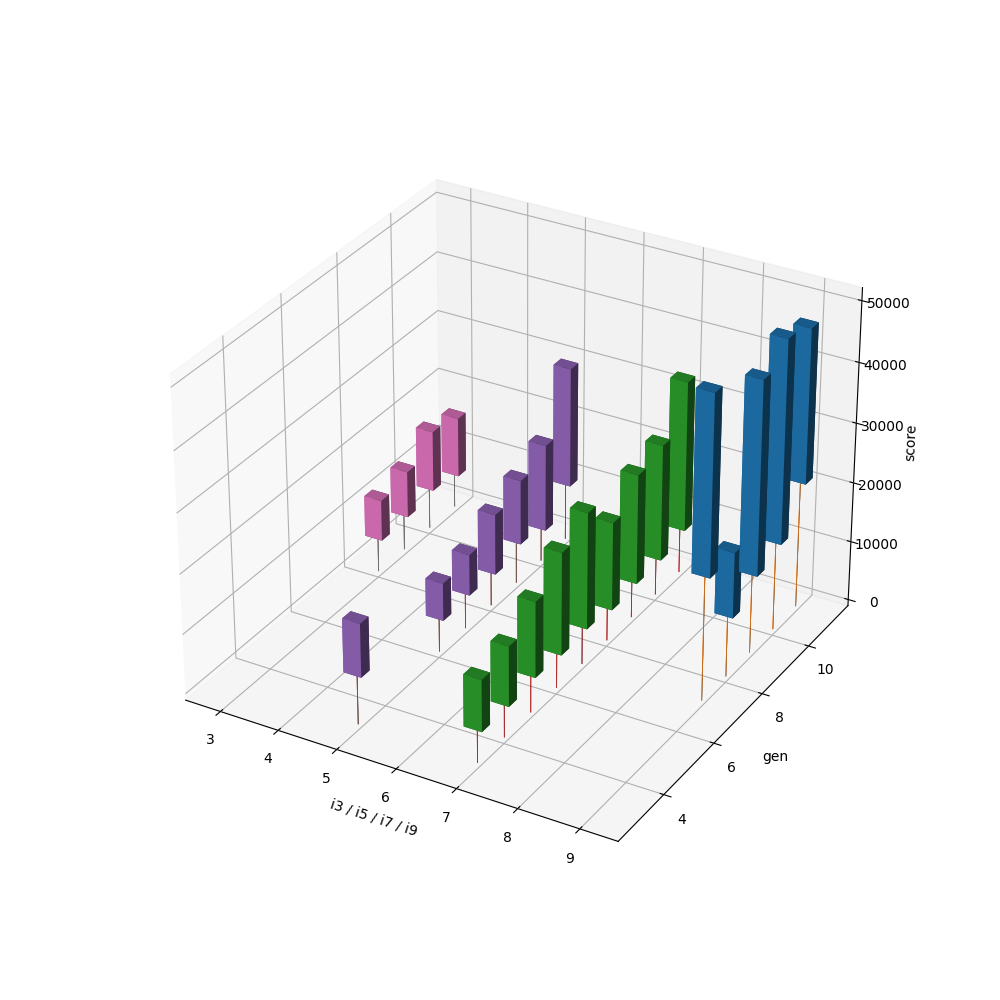

In [14]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')

#ax.plot3D(ptmp["class"], ptmp["gen"], ptmp["count"], "o")
for c in pdata5["cls"].drop_duplicates():
    ptmp = pdata5[pdata5["cls"]==c]
    sz = ptmp.shape[0]
    # 上面的粗线
    diff = 0.3
    x = ptmp["cls"]
    y = ptmp["gen"]
    z = ptmp["min"]
    dx = np.ones(sz) * diff
    dy = np.ones(sz) * diff
    dz = ptmp["max"]
    ax.bar3d(x-diff/2, y-diff/2, z, dx, dy, dz)
    # 下面的细线
    diff0 = 0.01
    z0 = np.ones(sz) * 0
    dx0 = np.ones(sz) * diff0
    dy0 = np.ones(sz) * diff0
    ax.bar3d(x, y, z0, dx0, dy0, z)

ax.set_xlabel("i3 / i5 / i7 / i9")
ax.set_ylabel("gen")
ax.set_zlabel("score")
ax.set_zlim(bottom=0)
plt.show()

In [ ]:
fig = plt.figure()
ax = fig.add_subplot()
x, y = np.random.rand(2, 100) * 4
plt.hist(x, bins=10)
plt.show()